### Implementation of Hierarchical Agents for Document Generation

- In our Agent Supervisor, we introduced the concept of a single supervisor node to route work between different worker nodes. For some applications, the system may be more effective if work is distributed hierarchically. You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors. 
- Architecture is shown below

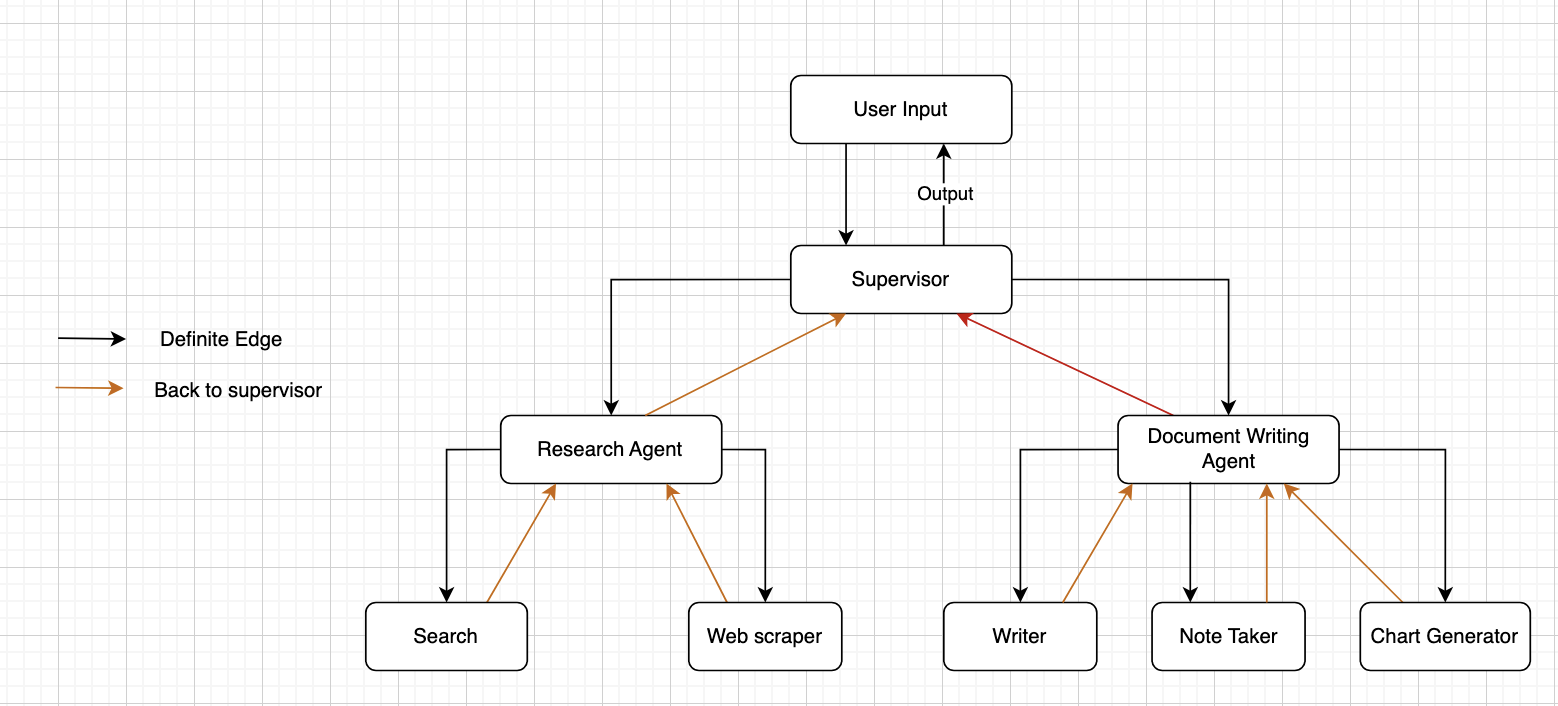

In [1]:
from IPython.display import Image
Image(filename='architecture.png')

#### Create Tools

- ResearchTeam tools: The research team can use a search engine and url scraper to find information on the web.
- Document writing team tools: We will give some tools for the doc writing team to use.

In [25]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

2025-02-24 20:52:49,814 - 7999446080 - user_agent.py-user_agent:11 - WARNING: USER_AGENT environment variable not set, consider setting it to identify your requests.


In [26]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

#### Helper Utilities

- We are going to create a few utility functions to make it more concise when we want to:
    1. Create a worker agent.
    2. Create a supervisor for the sub-graph.

In [27]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

class State(MessagesState):
    next: str

def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

#### Define Agent Teams

- Research Team: The research team will have a search agent and a web scraping "research_agent" as the two worker nodes.

In [28]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini")

search_agent = create_react_agent(llm, tools=[tavily_tool])

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [29]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

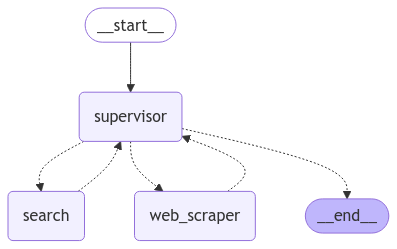

In [30]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [31]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Taylor Swift\'s next tour, the "Eras Tour," will begin its final leg on **October 18, 2024**, at Hard Rock Stadium near Miami. The last show of this leg is scheduled for **December 8, 2024**, at BC Place in Vancouver. The tour will continue into 2024 with additional dates in the U.S., Canada, and international locations, including South America, Asia, Australia, and Europe.\n\nFor more details, you can check out the following sources:\n- [azcentral.com](https://www.azcentral.com/story/entertainment/music/2024/09/10/taylor-swift-eras-tour-dates-2024/75109891007/)\n- [today.com](https://www.today.com/popculture/music/taylor-swift-eras-tour-2024-canada-us-dates-rcna97970)', additional_kwargs={}, response_metadata={}, name='search', id='569851c0-12bf-42c0-b181-f8afb72fd70a')]}}
---
{'supervisor': {'next': '__end__'}}
---


- Document Writing Team: Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

In [33]:
llm = ChatOpenAI(model="gpt-4o-mini")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [34]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

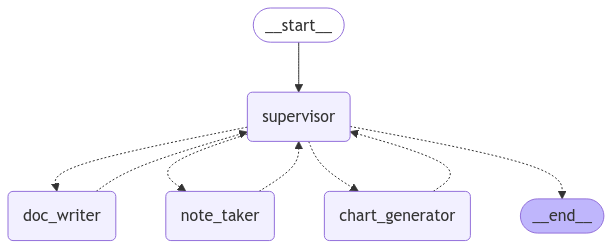

In [35]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [36]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The outline for the poem about cats has been saved as "cats_poem_outline.txt," and the poem itself has been saved as "cats_poem.txt."', additional_kwargs={}, response_metadata={}, name='doc_writer', id='f6dd07f2-116f-4d35-8e63-276f240f7aa7')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about cats has been saved as "cats_poem_outline.txt." Here is the poem titled "Whiskers and Whimsy" saved as "cats_poem.txt":\n\n---\n\n**Whiskers and Whimsy**  \n\nIn shadows deep, where secrets lie,  \nA creature roams, with watchful eye.  \nSoft fur, like whispers, brushes past,  \nA feline spirit, free and vast.  \n\nWith grace they glide, as moonbeams dance,  \nIn every leap, a fleeting chance.  \nEmerald orbs, so bright, so keen,  \nReflect the worlds they\'ve always seen.  \n\nCurled in sunbeams, lost in dreams,  \nThey chase

#### Supervisor Agent

- In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.
- We'll create a third graph to orchestrate the previous two. 

In [37]:
from langchain_core.messages import BaseMessage
llm = ChatOpenAI(model="gpt-4o-mini")
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [38]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

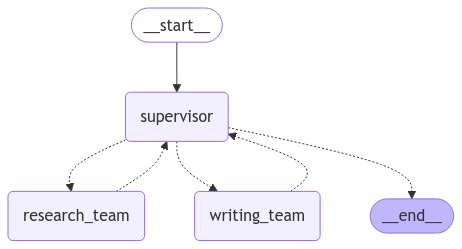

In [39]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [40]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="### Brief Report on AI Agents (2023)\n\n**Introduction to AI Agents**\nAI agents are software entities designed to perform tasks autonomously or semi-autonomously, leveraging artificial intelligence (AI) and machine learning (ML) technologies. They interact with users, process data, and make decisions based on defined parameters. The development of AI agents has accelerated due to advancements in natural language processing, machine learning, and complex algorithms.\n\n**Market Overview**\nThe global AI agents market is estimated to be valued at USD 5.40 billion in 2024, with projections indicating a significant growth trajectory, reaching USD 50.31 billion by 2030. This represents a compound annual growth rate (CAGR) of approximately 45.8% from 2025 to 2030. The surge in demand for automation, enhanced customer experiences, and increased adoption of cloud computing are key drivers of th